
#**A Future Frame Prediction System Based on PredNet Architecture**
Kshitija Ghate \
Student ID: 210817540 \


In [1]:
# Connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **All Imports and Notebook Settings**


My dataset files are saved on google drive, and I am facing issues with downloading my google drive files using **gdown**.
I am sharing the dataset folder link. Please copy the files to your google drive.


Dataset Link
https://drive.google.com/drive/folders/1PPsqXkalYy7XaoPeNJGpImXowzpwL0p5?usp=sharing

In [ ]:
# #@title Download Saved Model
# !pip install --upgrade --no-cache-dir  gdown==4.3.0
# # !pip install -U --no-cache-dir gdown --pre
# !gdown --id '1-M-Skk4PJW1YA2HTDktS6ZF6W4XPSHqP'
# import gdown, os

# url = "https://drive.google.com/drive/folders/1PPsqXkalYy7XaoPeNJGpImXowzpwL0p5?usp=sharing"

# download_successful = None # A workaround to make sure that gdown downloads the whole folder successfully, see https://github.com/wkentaro/gdown/issues/43
# while download_successful == None:
#   download_successful = gdown.download_folder(url, quiet=True, use_cookies=False)
#   os.system('rm ~/.cache/gdown/cookies.json')



In [2]:
# install hickle
!pip install hickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import all dependencies
%tensorflow_version 2.x
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import subprocess, os
import numpy as np
import hickle as hkl
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.backend import hard_sigmoid
from tensorflow.keras.layers import UpSampling2D

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# data.py

Preprocess the dataset


In [4]:
class DataLoad():
    def __init__(self):
        pass


    def __getitem__(self,i):
        loc = self.snippet_starts[i]
        return self.x[loc:loc+time_steps]

    def __len__(self):
        return len(self.snippet_starts)

    def __call__(self, dataset_file,dataset_info,time_steps):
        self.dataset_file = dataset_file
        self.dataset_info = dataset_info
        self.x = hkl.load(self.dataset_file)
        self.info = hkl.load(self.dataset_info)

        self.time_steps = time_steps

        curr_location = 0
        snippets = []


        while curr_location < self.x.shape[0] - self.time_steps + 1:
            if self.info[curr_location] == self.info[curr_location+time_steps - 1]:
                one_snippet = self.x[curr_location:curr_location+time_steps]
                
                snippets.append(one_snippet)
                
                curr_location += time_steps
            else:
                curr_location+=1

        self.snippets = snippets
        snippets_list = np.array(self.snippets).astype(np.float32)
        snippets_list = snippets_list / 255

        return snippets_list

    def _create_batch(self,arr, batch_size):

        length = arr.shape[0]
        start_index = 0
        end_index = batch_size
        arr_batches = []

        while end_index <= length:
            arr_batches.append(arr[start_index: end_index])
            start_index += batch_size
            end_index = start_index+ batch_size

        return arr_batches

#var.py
All variables

In [5]:
#dataset paths

# dir = "kitti_hkl"
dir = '/content/drive/MyDrive/kitti_hkl'

train_dataset_url = os.path.join(dir, "X_train.hkl")
train_source_url = os.path.join(dir, "sources_train.hkl")
test_dataset_url = os.path.join(dir,"X_test.hkl")
test_source_url = os.path.join(dir, "sources_test.hkl")


# image shape
img_shape = (128,160,3)


# hyperparameters

time_steps = 10
num_sequences = None
batch_size = 4

# training settings


#learning rate

lr = 0.001

# test setting

num_pred_frames = 10




#model.py

PredNet model implementation

In [6]:
# output_channels for each layer
layer_out_channels = (3, 48, 96, 192)


##### model #####

# ConvLSTM 

class ConvLSTM(layers.Layer):
    """imprementation of Convolutional LSTM
    referring to
        https://github.com/takyamamoto/PredNet_Chainer/blob/master/network.py
        https://github.com/joisino/ConvLSTM/blob/master/network.py
        http://joisino.hatenablog.com/entry/2017/10/27/200000
        https://github.com/kn-lambda/Pred-Net/blob/master/model.py

    """

    def __init__(self, out_channels, kernel_size=3):
        super(ConvLSTM, self).__init__()

        # convolution settings
        # before fed into the first activation, channel size is enlarged to "out_channels"
        # and in after layers, channel size is not changed
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # to the first activation
        self.Wxc = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same")
        self.Whc = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same", use_bias=False)
        # to input gate
        self.Wxi = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same")
        self.Whi = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same", use_bias=False)
        # to forget gate
        self.Wxf = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same")
        self.Whf = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same", use_bias=False)
        # to  output gate
        self.Wxo = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same")
        self.Who = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same", use_bias=False)

        # peepholes
        # initialized when used for the first time
        self.Wci = None
        self.Wcf = None
        self.Wco = None

        # reset internal states
        self.reset_state()

    def reset_state(self, c=None, h=None):
        self.c = c
        self.h = h

    def _initialize_peephole(self, height, width):
        shape = (height, width, self.out_channels)
        self.Wci = tf.Variable(tf.zeros(shape))
        self.Wcf = tf.Variable(tf.zeros(shape))
        self.Wco = tf.Variable(tf.zeros(shape))

    def _initialize_state(self, x):
        # The following calculation is not elegant.
        # To initialize 'c', 'h', their 4-dim shape is required,
        # especially, the batch-size must be given which may be unknown when constructing the graph.
        # To avoid explicitly using batch-size, abstract input tenor 'x' is fed into the convolution
        # until we get the desired shape.
        tmp = self.Wxc(x)
        self.c = tf.zeros_like(tmp)
        self.h = tf.zeros_like(tmp)

    def __call__(self, x):
        """one-step execution of convLSTM
        Args:
            x : 4-dim (batch_size, height, width, channel) tensor
        """
        assert len(x.shape) == 4, "the dimension of the input tensor must be {}, but {}.".format(4, len(x.shape))
        
        if self.Wci is None:
            self._initialize_peephole(x.shape[1], x.shape[2])

        if self.c is None:
            self._initialize_state(x)

        ig = hard_sigmoid(self.Wxi(x) + self.Whi(self.h) + self.c * self.Wci)  # input gate
        fg = hard_sigmoid(self.Wxf(x) + self.Whf(self.h) + self.c * self.Wcf)  # forget gate
        new_c = fg * self.c + ig * tf.tanh(self.Wxc(x) + self.Whc(self.h))
        og = hard_sigmoid(self.Wxo(x) + self.Who(self.h) + new_c * self.Wco)  # output gate
        new_h = og * tf.tanh(new_c)

        self.c = new_c
        self.h = new_h
        
        return new_h


class R_block(layers.Layer):

    # Representation block in prednet

    def __init__(self, out_channels):
        super(R_block, self).__init__()
        # conv lstm layer
        self.convlstm = ConvLSTM(out_channels=out_channels)

        # output umsampled and passed to bottom layer R block
        self.up_sampling = UpSampling2D(size=(2,2))
        

    def reset_state(self):
        self.convlstm.reset_state()


    def __call__(self, previous_R,previous_E, top_R=None):
        """
         previous_R: previous time(t-1) step value of R same layer
         previous_E: previous time(t-1) step value E same layer
         top_R: next layer R value in same time step(t)

         return value
         R for current time step(t)
        """

        if top_R is not None:
            up_R = self.up_sampling(top_R)            
            lstm_input = tf.concat([previous_R,previous_E,up_R],axis=3) #concat with channel dim

        else:
            lstm_input = tf.concat([previous_R,previous_E],axis=3)
            
        R = self.convlstm(lstm_input)        
        return R


class E_block(layers.Layer):

    """
    prediction and error block

    """
    def __init__(self, out_channels,kernel_size=3,pixel_max=1.0, bottom=False):
        super(E_block, self).__init__()

        self.pixel_max = pixel_max
        self.bottom = bottom
        # down_sampling
        self.down_sampling = layers.MaxPool2D(pool_size = 2, strides=2, padding="same")
        self.pred_conv = layers.Conv2D(filters=out_channels,kernel_size=kernel_size,padding="same")

        if bottom == False:
            self.target_conv = layers.Conv2D(filters=out_channels,kernel_size=kernel_size,padding="same")

    def __call__(self,R, bottom_E=None):
        """
        Args:
            bottom_E: bottom layer error in same time step
            R: current layer R value in same time step

        return value
        E : error value
        A_pred: generated prediction
        A_target: given target frame

        """

        if self.bottom == False:
            A_pred = tf.nn.relu(self.pred_conv(R))
            A_target = self.down_sampling(tf.nn.relu(self.target_conv(bottom_E)))
        else:
            # for bottom layer
            A_pred =  tf.clip_by_value(tf.nn.relu(self.pred_conv(R)),0.0, self.pixel_max)

            # input frame is sent to bottom_E

            if bottom_E is None:
                A_target = A_pred
            else:
                A_target = bottom_E

        # calculate error
        E = tf.concat([tf.nn.relu(A_pred - A_target),tf.nn.relu(A_target - A_pred)], axis=3)
        return E, A_pred

    


class prednet(tf.keras.Model):
    """
    prednet model structure

    """

    def __init__(self, out_channels=layer_out_channels):
        super(prednet, self).__init__()
        """
        layer_
        out_channels: tuple contains number of channels for each layer
        """
        self.out_channels = out_channels
        #total layers
        self.num_layers = len(out_channels)

        for layer in range(self.num_layers):
            setattr(self, "R_block"+str(layer), R_block(out_channels=out_channels[layer]))
            
            if layer == 0:
                setattr(self,"E_block"+str(layer),E_block(out_channels[layer], bottom=True))

            else:
                setattr(self, "E_block"+str(layer),E_block(out_channels[layer]))

        self.reset_state()


    def reset_state(self):
        # reset value for each layer
        self.E = None
        self.R = None


    def _one_step(self,x):

        """
        R is updated top to bottom
        next frame is predicted and comapred with ground truth input frame
        Next, E is updated bottom to top

        args
        x : 4-dim(batch_size, width,height,channels)

        """
        
        if x is not None:
            assert len(x.shape)  == 4, "input tensor dimension should be {}, but {} is given.".format(4,len(x.shape))

        if self.E is None:
            self.E = []
            self.R = []

            temp_A = tf.zeros_like(x,tf.float32)


            for layer in range(self.num_layers):
                """
                
                double the number of channels
                
                """
                double_channels = layers.Conv2D(filters = 2*self.out_channels[layer], kernel_size = 1,trainable =False,kernel_initializer = tf.zeros_initializer())

                # shape of E is twice the shape of A
                temp_E = double_channels(temp_A)
                
                self.E.append(tf.zeros_like(temp_E))


                # shape of R = shape of A
                self.R.append(tf.zeros_like(temp_A))


                getattr(self, "R_block"+str(layer)).reset_state()

                if layer != self.num_layers-1:
                    # change the size of temp A for next layer
                    next_layer_dim = layers.Conv2D(filters= self.out_channels[layer+1],kernel_size=2,strides=2,trainable=False,kernel_initializer=tf.zeros_initializer())
                    temp_A = next_layer_dim(temp_A)
                    

        # top down calculations for R block

        for layer in reversed(range(self.num_layers)):
            if layer != self.num_layers-1:
                updated_R = getattr(self, "R_block"+str(layer))(self.R[layer], self.E[layer],self.R[layer+1])
            else:
                updated_R = getattr(self,"R_block"+str(layer))(self.R[layer],self.E[layer])


            self.R[layer] = updated_R


        # bottom up calculation for E block

        for layer in range(self.num_layers-1):
            if layer!=0:
                updated_E,_ =getattr(self, "E_block"+str(layer))(self.R[layer],self.E[layer-1])

            else:
                updated_E, pred = getattr(self,"E_block"+str(layer))(self.R[layer],x)

            self.E[layer] = updated_E

        temp_loss = tf.reduce_mean(self.E[0]) # consider loss for this time step

        return temp_loss, pred


    @tf.function 
    def __call__(self,x,num_pred_frames=0):
        """
        Args
        x :  5 dimension (batch_size,time_step, width, height, channels)
        num_pred_frames: number of future predicted frames
        """
        
        assert len(x.shape) == 5, "the dimension of the input tensor must be{}, but{} is given.".format(5,len(x.shape))

        time_steps = x.shape[1]

        total_loss=0
        pred_frame_list = []
        self.reset_state()

        #predict for each time step
        for t in range(time_steps+num_pred_frames):

            if t < time_steps:
                x_t = x[:,t,:,:,:]
            else:
                x_t = None


            loss, pred = self._one_step(x_t)            
            pred_frame_list.append(pred)

            if t > 0 and t< time_steps:
                total_loss += loss

        total_loss = total_loss/(time_steps-1)

        return total_loss, pred_frame_list

    

                    








#visualize.py
utility functions to plot images


In [7]:


class VisualizeData(object):
    def __init__(self):
        pass
    
    def __call__(self, sample, num_frames,groundtruth=False):
        # Construct a figure on which we will visualize the images.
        
        assert num_frames % 5 == 0, "The number of frames must be a multiple of 5 but{} is given.".format(num_frames)
        rows = num_frames/5
        fig, axes = plt.subplots(int(rows),5, figsize=(8, 6))
        

        # set the spacing between subplots
        plt.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)

        for idx, ax in enumerate(axes.flat):
            ax.imshow(np.squeeze(sample[idx]))
            ax.set_title(f"Frame {idx + 1}")
            ax.axis("off")

        plt.show()



#train.py

/usr/local/lib/python3.7/dist-packages/hickle/hickle.py:556: UserWarning: Input argument 'file_obj' appears to be a file made with hickle v3. Using legacy load...
  warnings.warn("Input argument 'file_obj' appears to be a file made"


train data (4114, 10, 128, 160, 3)
test data (83, 10, 128, 160, 3)


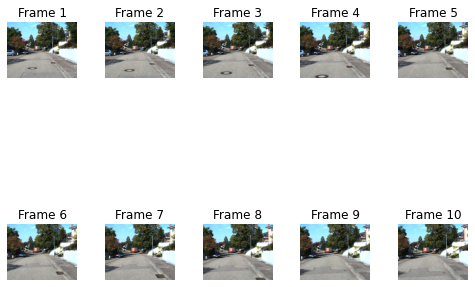

train batch (1028, 4, 10, 128, 160, 3)
test batch (20, 4, 10, 128, 160, 3)
Epoch:0/25 ----loss : 0.019394440576434135
Epoch:1/25 ----loss : 0.01626012846827507
Epoch:2/25 ----loss : 0.013737987726926804
Epoch:3/25 ----loss : 0.012895246967673302
Epoch:4/25 ----loss : 0.012095834128558636
Epoch:5/25 ----loss : 0.011744524352252483
Epoch:6/25 ----loss : 0.011382237076759338
Epoch:7/25 ----loss : 0.01094913762062788
Epoch:8/25 ----loss : 0.010693310759961605
Epoch:9/25 ----loss : 0.01063790637999773
Epoch:10/25 ----loss : 0.010676464065909386
Epoch:11/25 ----loss : 0.01034578401595354
Epoch:12/25 ----loss : 0.010265596210956573
Epoch:13/25 ----loss : 0.010271910578012466
Epoch:14/25 ----loss : 0.010111070238053799
Epoch:15/25 ----loss : 0.010144580155611038
Epoch:16/25 ----loss : 0.009959366172552109
Epoch:17/25 ----loss : 0.009930653497576714
Epoch:18/25 ----loss : 0.009869988076388836
Epoch:19/25 ----loss : 0.009825233370065689
Epoch:20/25 ----loss : 0.009748254902660847
Epoch:21/25 ---

In [8]:
# import tensorflow as tf
# import subprocess, os
# import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

# # import from data

# from data import DataLoad
# from model import prednet


# import from var
# from var import  img_shape, num_pred_frames, time_steps, batch_size, iterations, lr
# from var import train_dataset_url, test_dataset_url, train_source_url, test_source_url
# from visualize import VisualizeData


# check for gpu
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')


# load data
dl_obj = DataLoad()


train_data = dl_obj(train_dataset_url,train_source_url,time_steps)
test_data = dl_obj(test_dataset_url,test_source_url,time_steps)


train_data = np.array(train_data)
test_data = np.array(test_data)

print("train data",np.array(train_data).shape)
print("test data",np.array(test_data).shape)


# visualize video snippet sample data
vi_obj = VisualizeData()
sample_id = np.random.choice(range(len(train_data)),size=1)[0]
vi_obj(train_data[sample_id],10)


train_batch = dl_obj._create_batch(train_data,batch_size)
test_batch = dl_obj._create_batch(test_data,batch_size)



# prednet model

model = prednet()
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)


###### Training ######

epochs = 25

train_loss = np.zeros(shape=(epochs))

for e in range(epochs):
    for batch in train_batch:
        with tf.GradientTape() as tape:
          loss, pred_frame_list = model(batch,num_pred_frames)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_loss[e] = loss

    print('Epoch:{}/{} ----loss : {}'.format(e,epochs,loss))







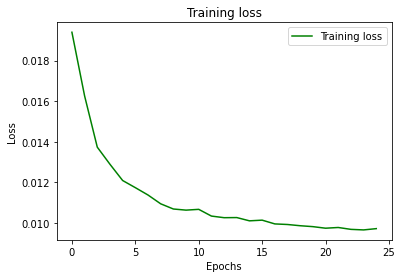

In [9]:

plt.plot(np.arange(0,epochs), train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#predict.py

/usr/local/lib/python3.7/dist-packages/hickle/hickle.py:556: UserWarning: Input argument 'file_obj' appears to be a file made with hickle v3. Using legacy load...
  warnings.warn("Input argument 'file_obj' appears to be a file made"


20


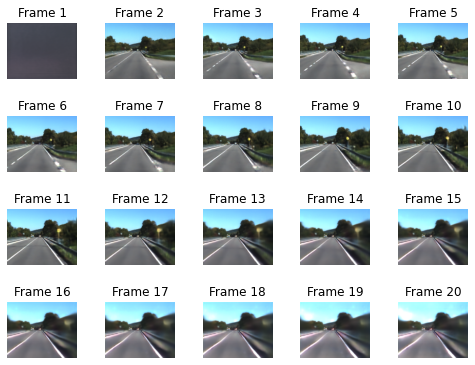

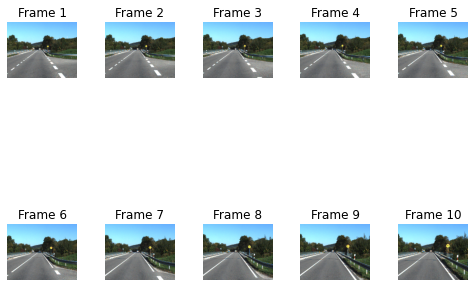

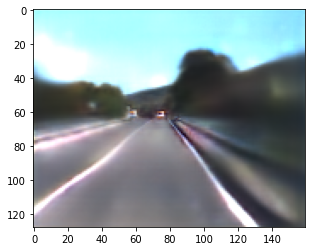

SSIM values for first 10 frames
[0.404911846 0.750548184 0.799734294 0.81019944 0.722136319 0.786046922 0.763576567 0.776286781 0.789989412 0.792633116]


In [10]:
# from train import model
# from var import  img_shape, num_pred_frames, time_steps, batch_size, iterations, lr
# from var import  test_dataset_url, test_source_url
# from visualize import VisualizeData

import tensorflow as tf
import numpy as np

# from data import DataLoad

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation


# check for gpu
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
# print(is_cuda_gpu_available)

# load test data
dl_obj = DataLoad()
test_data = dl_obj(test_dataset_url,test_source_url,time_steps)
test_data = np.array(test_data)
test_batch = dl_obj._create_batch(test_data,batch_size)


# visualize video snippet
vi_obj = VisualizeData()

test_batch_sample_id = np.random.choice(range(np.array(test_batch).shape[0]),size=1)[0]
loss,pred_frame_list = model(test_batch[test_batch_sample_id],10)

pred_frame_list = np.array(np.swapaxes(pred_frame_list,0,1))

display_sample_id = np.random.choice(range(len(pred_frame_list)),size=1)[0]

vi_obj(pred_frame_list[display_sample_id],10+num_pred_frames)

vi_obj(test_batch[test_batch_sample_id][display_sample_id],10)


# generate video

frames = [] # for storing the generated images
sample_test = pred_frame_list[display_sample_id]

fig = plt.figure()
for i in range(len(sample_test)):
    frames.append([plt.imshow(sample_test[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('/content/drive/MyDrive/prednet_model/video/video.mp4')
plt.show()

# Calculate ssim for first 10 frames

ssim_value = tf.image.ssim(test_batch[test_batch_sample_id][display_sample_id], sample_test[:10], max_val=1, filter_size=11,
                      filter_sigma=1.5, k1=0.01, k2=0.03)
print("SSIM values for first 10 frames")
tf.print(ssim_value,summarize=10)
  
  

In [ ]:
plt.plot(np.arange(0,10), ssim_value, label='SSIM values')
plt.title(' structural similarity index measure (SSIM) for L0 loss')
plt.xlabel('Predicted Frames')
plt.ylabel('SSIM values')
plt.legend()
plt.show()